In [109]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

In [110]:
#sequence_2018_05_07-19.06.27.csv
# df = pd.read_csv('sequences/occupancy_3.csv')
# seq_names = ['light_code', 'temperature', 'occupancy']
df = pd.read_csv("sequences/occupancy_3.csv")


from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
df["light"] = lb.fit_transform(df["light"])
df.head()

,light,temperature,occupancy
0,0,19.0,0.0
1,0,19.0,0.0
2,0,19.0,0.0
3,0,19.0,0.0
4,0,19.0,0.0


In [111]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['light'] = min_max_scaler.fit_transform(df.light.values.reshape(-1,1))
    df['temperature'] = min_max_scaler.fit_transform(df.temperature.values.reshape(-1,1))
    df['occupancy'] = min_max_scaler.fit_transform(df.occupancy.values.reshape(-1,1))
    #df['attr_4'] = min_max_scaler.fit_transform(df.attr_4.values.reshape(-1,1))    
    x = df['temperature'] = min_max_scaler.fit_transform(df.temperature.values.reshape(-1,1))
    df['temperature'] = df['occupancy']
    df['occupancy'] = x
    return df
df = normalize_data(df)
df.head()

C:\Users\ekamjur\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,light,temperature,occupancy
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [113]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = round(0.75 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [114]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [115]:
window = 15
X_train, y_train, X_test, y_test = load_data(df, window)
print (X_train[0], y_train[0])

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [1.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.66666667]
 [0.         0.         0.        ]] 0.0


C:\Users\ekamjur\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [116]:
model = build_model([3,window,1])

Compilation Time :  0.03126692771911621


In [117]:
model.fit(X_train,y_train,batch_size=512,epochs=20,validation_split=0.1,verbose=1)

Train on 4849 samples, validate on 539 samples
Epoch 1/20
4849/4849 [==============================] - 7s 1ms/step - loss: 0.2243 - acc: 0.5488 - val_loss: 0.0357 - val_acc: 0.7217
Epoch 2/20
4849/4849 [==============================] - 6s 1ms/step - loss: 0.0627 - acc: 0.7410 - val_loss: 0.0514 - val_acc: 0.7180
Epoch 3/20
4849/4849 [==============================] - 8s 2ms/step - loss: 0.0422 - acc: 0.7523 - val_loss: 0.0305 - val_acc: 0.7217
Epoch 4/20
4849/4849 [==============================] - 7s 2ms/step - loss: 0.0312 - acc: 0.7550 - val_loss: 0.0316 - val_acc: 0.7217
Epoch 5/20
4849/4849 [==============================] - 8s 2ms/step - loss: 0.0290 - acc: 0.7548 - val_loss: 0.0298 - val_acc: 0.7217
Epoch 6/20
4849/4849 [==============================] - 8s 2ms/step - loss: 0.0281 - acc: 0.7546 - val_loss: 0.0300 - val_acc: 0.7217
Epoch 7/20
4849/4849 [==============================] - 9s 2ms/step - loss: 0.0279 - acc: 0.7550 - val_loss: 0.0294 - val_acc: 0.7217
Epoch 8/20
4849

In [118]:
print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
    # print(p[-1]) 

[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
(1796, 1)


In [119]:
df = pd.read_csv("sequences/occupancy_3.csv")

def denormalize(df, normalized_value): 
    #df["light"] = lb.fit_transform(df["light"])
    df = df['temperature'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, p)
newy_test = denormalize(df, y_test)

In [120]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.02615 MSE (0.16 RMSE)
Test Score: 0.03010 MSE (0.17 RMSE)


(0.026151298431910535, 0.03009762388150019)

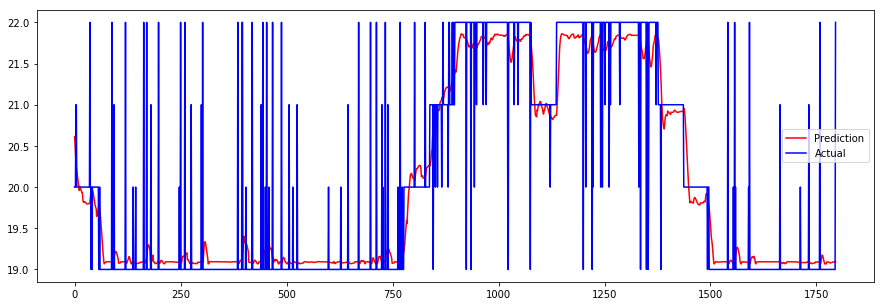

In [121]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

In [ ]:
print(len(y_test), len(y_train))

In [122]:
import sys
sys.path.append('./detectors/')
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal
from online_simulator import OnlineSimulator
from rules_detector import RulesDetector
from utils import *
from zscore_detector import ZScoreDetector

In [123]:
df = pd.read_csv('sequences/occupancy_3.csv')
seq_names = ['light_code', 'temperature', 'occupancy']
df['ind'] = [x for x in range(len(df['light']))]
#df.set_index('ind')
#print (df.index.name)
df['date'] = pd.to_datetime(df['ind'], unit='m')
df['date'] = df['date'] + pd.DateOffset(years=48)
df['date'] = df['date'] + pd.DateOffset(months=7)
print(df.head())
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
df["light_code"] = lb.fit_transform(df["light"])

predict_ratio=0.73
base_seqs =[]

for name in seq_names:
    base_seqs.append(np.array(df[name]))

sequences = [[] for i in range(len(base_seqs))]
for nr in range(1):
    for i, seq in enumerate(sequences):
        sequences[i] = np.concatenate((seq, base_seqs[i]))

   light  temperature  occupancy  ind                date
0  'OFF'         19.0        0.0    0 2018-08-01 00:00:00
1  'OFF'         19.0        0.0    1 2018-08-01 00:01:00
2  'OFF'         19.0        0.0    2 2018-08-01 00:02:00
3  'OFF'         19.0        0.0    3 2018-08-01 00:03:00
4  'OFF'         19.0        0.0    4 2018-08-01 00:04:00


In [125]:
win_size = 20
detector2 = ZScoreDetector(window_size = 25, threshold=4)
# detector1 = ZScoreDetector(window_size = 30, threshold=5)
detector1 = ZScoreDetector(window_size = 30, threshold=4.5)
detector3 = ZScoreDetector(window_size = 30, threshold=4)

rules_detector = RulesDetector(target_seq_index=1,
                               window_size=1440,
                               round_to=60,
                               type="all",
                               combined=False)

simulator = OnlineSimulator(rules_detector,
                            [detector1, detector2, detector3],
                            sequences,
                            seq_names,
                            round_to=60,
                            predict_ratio=predict_ratio)
simulator.label_encoder = lb

./detectors\zscore_detector.py:65: RuntimeWarning: invalid value encountered in double_scalars
  self.std_diff = (g_std - w_std) / g_std
./detectors\zscore_detector.py:67: RuntimeWarning: invalid value encountered in double_scalars
  self.mean_diff = (g_mean_ - w_mean) / g_mean_
./detectors\zscore_detector.py:69: RuntimeWarning: invalid value encountered in double_scalars
  self.z_score_ = (w_mean - g_mean_) / self.SE


0
0
0
1
1
1
2
2
2
3
3
3
4
4
4
5
5
5
6
6
6
7
7
7
8
8
8
9
9
9
10
10
10
11
11
11
12
12
12
13
13
13
14
14
14
15
15
15
16
16
16
17
17
17
18
18
18
19
19
19
20
20
20
21
21
21
22
22
22
23
23
23
24
24
24
25
25
25
26
26
26
27
27
27
28
28
28
29
29
29
30
30
30
31
31
31
32
32
32
33
33
33
34
34
34
35
35
35
36
36
36
37
37
37
38
38
38
39
39
39
40
40
40
41
41
41
42
42
42
43
43
43
44
44
44
45
45
45
46
46
46
47
47
47
48
48
48
49
49
49
50
50
50
51
51
51
52
52
52
53
53
53
54
54
54
55
55
55
56
56
56
57
57
57
58
58
58
59
59
59
60
60
60
61
61
61
62
62
62
63
63
63
64
64
64
65
65
65
66
66
66
67
67
67
68
68
68
69
69
69
70
70
70
71
71
71
72
72
72
73
73
73
74
74
74
75
75
75
76
76
76
77
77
77
78
78
78
79
79
79
80
80
80
81
81
81
82
82
82
83
83
83
84
84
84
85
85
85
86
86
86
87
87
87
88
88
88
89
89
89
90
90
90
91
91
91
92
92
92
93
93
93
94
94
94
95
95
95
96
96
96
97
97
97
98
98
98
99
99
99
100
100
100
101
101
101
102
102
102
103
103
103
104
104
104
105
105
105
106
106
106
107
107
107
108
108
108
109
109
109
110
110
11

747
748
748
748
749
749
749
750
750
750
751
751
751
752
752
752
753
753
753
754
754
754
755
755
755
756
756
756
757
757
757
758
758
758
759
759
759
760
760
760
761
761
761
762
762
762
763
763
763
764
764
764
765
765
765
766
766
766
767
767
767
768
768
768
769
769
769
770
770
770
771
771
771
772
772
772
773
773
773
774
774
774
775
775
775
776
776
776
777
777
777
778
778
778
779
779
779
780
780
780
781
781
781
782
782
782
783
783
783
784
784
784
785
785
785
786
786
786
787
787
787
788
788
788
789
789
789
790
790
790
791
791
791
792
792
792
793
793
793
794
794
794
795
795
795
796
796
796
797
797
797
798
798
798
799
799
799
800
800
800
801
801
801
802
802
802
803
803
803
804
804
804
805
805
805
806
806
806
807
807
807
808
808
808
809
809
809
810
810
810
811
811
811
812
812
812
813
813
813
814
814
814
815
815
815
816
816
816
817
817
817
818
818
818
819
819
819
820
820
820
821
821
821
822
822
822
823
823
823
824
824
824
825
825
825
826
826
826
827
827
827
828
828
828
829
829
829
830
830
830


1478
1479
1479
1479
1480
1480
1480
1481
1481
1481
1482
1482
1482
1483
1483
1483
1484
1484
1484
1485
1485
1485
1486
1486
1486
1487
1487
1487
1488
1488
1488
1489
1489
1489
1490
1490
1490
1491
1491
1491
1492
1492
1492
1493
1493
1493
1494
1494
1494
1495
1495
1495
1496
1496
1496
1497
1497
1497
1498
1498
1498
1499
1499
1499
1500
1500
1500
1501
1501
1501
1502
1502
1502
1503
1503
1503
1504
1504
1504
1505
1505
1505
1506
1506
1506
1507
1507
1507
1508
1508
1508
1509
1509
1509
1510
1510
1510
1511
1511
1511
1512
1512
1512
1513
1513
1513
1514
1514
1514
1515
1515
1515
1516
1516
1516
1517
1517
1517
1518
1518
1518
1519
1519
1519
1520
1520
1520
1521
1521
1521
1522
1522
1522
1523
1523
1523
1524
1524
1524
1525
1525
1525
1526
1526
1526
1527
1527
1527
1528
1528
1528
1529
1529
1529
1530
1530
1530
1531
1531
1531
1532
1532
1532
1533
1533
1533
1534
1534
1534
1535
1535
1535
1536
1536
1536
1537
1537
1537
1538
1538
1538
1539
1539
1539
1540
1540
1540
1541
1541
1541
1542
1542
1542
1543
1543
1543
1544
1544
1544
1545


2263
2264
2264
2264
2265
2265
2265
2266
2266
2266
2267
2267
2267
2268
2268
2268
2269
2269
2269
2270
2270
2270
2271
2271
2271
2272
2272
2272
2273
2273
2273
2274
2274
2274
2275
2275
2275
2276
2276
2276
2277
2277
2277
2278
2278
2278
2279
2279
2279
2280
2280
2280
2281
2281
2281
2282
2282
2282
2283
2283
2283
2284
2284
2284
2285
2285
2285
2286
2286
2286
2287
2287
2287
2288
2288
2288
2289
2289
2289
2290
2290
2290
2291
2291
2291
2292
2292
2292
2293
2293
2293
2294
2294
2294
2295
2295
2295
2296
2296
2296
2297
2297
2297
2298
2298
2298
2299
2299
2299
2300
2300
2300
2301
2301
2301
2302
2302
2302
2303
2303
2303
2304
2304
2304
2305
2305
2305
2306
2306
2306
2307
2307
2307
2308
2308
2308
2309
2309
2309
2310
2310
2310
2311
2311
2311
2312
2312
2312
2313
2313
2313
2314
2314
2314
2315
2315
2315
2316
2316
2316
2317
2317
2317
2318
2318
2318
2319
2319
2319
2320
2320
2320
2321
2321
2321
2322
2322
2322
2323
2323
2323
2324
2324
2324
2325
2325
2325
2326
2326
2326
2327
2327
2327
2328
2328
2328
2329
2329
2329
2330


2844
2844
2845
2845
2845
2846
2846
2846
2847
2847
2847
2848
2848
2848
2849
2849
2849
2850
2850
2850
2851
2851
2851
2852
2852
2852
2853
2853
2853
2854
2854
2854
2855
2855
2855
2856
2856
2856
2857
2857
2857
2858
2858
2858
2859
2859
2859
2860
2860
2860
2861
2861
2861
2862
2862
2862
2863
2863
2863
2864
2864
2864
2865
2865
2865
2866
2866
2866
2867
2867
2867
2868
2868
2868
2869
2869
2869
2870
2870
2870
2871
2871
2871
2872
2872
2872
2873
2873
2873
2874
2874
2874
2875
2875
2875
2876
2876
2876
2877
2877
2877
2878
2878
2878
2879
2879
2879
2880
2880
2880
2881
2881
2881
2882
2882
2882
2883
2883
2883
2884
2884
2884
2885
2885
2885
2886
2886
2886
2887
2887
2887
2888
2888
2888
2889
2889
2889
2890
2890
2890
2891
2891
2891
2892
2892
2892
2893
2893
2893
2894
2894
2894
2895
2895
2895
2896
2896
2896
2897
2897
2897
2898
2898
2898
2899
2899
2899
2900
2900
2900
2901
2901
2901
2902
2902
2902
2903
2903
2903
2904
2904
2904
2905
2905
2905
2906
2906
2906
2907
2907
2907
2908
2908
2908
2909
2909
2909
2910
2910
2910


3602
3602
3603
3603
3603
3604
3604
3604
3605
3605
3605
3606
3606
3606
3607
3607
3607
3608
3608
3608
3609
3609
3609
3610
3610
3610
3611
3611
3611
3612
3612
3612
3613
3613
3613
3614
3614
3614
3615
3615
3615
3616
3616
3616
3617
3617
3617
3618
3618
3618
3619
3619
3619
3620
3620
3620
3621
3621
3621
3622
3622
3622
3623
3623
3623
3624
3624
3624
3625
3625
3625
3626
3626
3626
3627
3627
3627
3628
3628
3628
3629
3629
3629
3630
3630
3630
3631
3631
3631
3632
3632
3632
3633
3633
3633
3634
3634
3634
3635
3635
3635
3636
3636
3636
3637
3637
3637
3638
3638
3638
3639
3639
3639
3640
3640
3640
3641
3641
3641
3642
3642
3642
3643
3643
3643
3644
3644
3644
3645
3645
3645
3646
3646
3646
3647
3647
3647
3648
3648
3648
3649
3649
3649
3650
3650
3650
3651
3651
3651
3652
3652
3652
3653
3653
3653
3654
3654
3654
3655
3655
3655
3656
3656
3656
3657
3657
3657
3658
3658
3658
3659
3659
3659
3660
3660
3660
3661
3661
3661
3662
3662
3662
3663
3663
3663
3664
3664
3664
3665
3665
3665
3666
3666
3666
3667
3667
3667
3668
3668
3668


4510
4510
4510
4511
4511
4511
4512
4512
4512
4513
4513
4513
4514
4514
4514
4515
4515
4515
4516
4516
4516
4517
4517
4517
4518
4518
4518
4519
4519
4519
4520
4520
4520
4521
4521
4521
4522
4522
4522
4523
4523
4523
4524
4524
4524
4525
4525
4525
4526
4526
4526
4527
4527
4527
4528
4528
4528
4529
4529
4529
4530
4530
4530
4531
4531
4531
4532
4532
4532
4533
4533
4533
4534
4534
4534
4535
4535
4535
4536
4536
4536
4537
4537
4537
4538
4538
4538
4539
4539
4539
4540
4540
4540
4541
4541
4541
4542
4542
4542
4543
4543
4543
4544
4544
4544
4545
4545
4545
4546
4546
4546
4547
4547
4547
4548
4548
4548
4549
4549
4549
4550
4550
4550
4551
4551
4551
4552
4552
4552
4553
4553
4553
4554
4554
4554
4555
4555
4555
4556
4556
4556
4557
4557
4557
4558
4558
4558
4559
4559
4559
4560
4560
4560
4561
4561
4561
4562
4562
4562
4563
4563
4563
4564
4564
4564
4565
4565
4565
4566
4566
4566
4567
4567
4567
4568
4568
4568
4569
4569
4569
4570
4570
4570
4571
4571
4571
4572
4572
4572
4573
4573
4573
4574
4574
4574
4575
4575
4575
4576
4576


5356
---START Predict sequence  seq_index: 0 curr_elem_index: 5356
[light_code(1.0){60; 66%}]
[light_code(1.0){120; 66%}]
[light_code(1.0){180; 66%}]
[light_code(1.0){240; 66%}]
[light_code(0.0){60; 66%}, light_code(1.0){240; 66%}]
[light_code(1.0){60; 92%}, light_code(0.0){60; 66%}, light_code(1.0){240; 66%}]
[light_code(1.0){120; 92%}, light_code(0.0){60; 66%}, light_code(1.0){240; 66%}]
[light_code(1.0){180; 92%}, light_code(0.0){60; 66%}, light_code(1.0){240; 66%}]
[light_code(1.0){240; 92%}, light_code(0.0){60; 66%}, light_code(1.0){240; 66%}]
[light_code(1.0){300; 92%}, light_code(0.0){60; 66%}, light_code(1.0){240; 66%}]
[light_code(0.0){60; 95%}, light_code(1.0){300; 92%}, light_code(0.0){60; 66%}, light_code(1.0){240; 66%}]
[light_code(0.0){120; 95%}, light_code(1.0){300; 92%}, light_code(0.0){60; 66%}, light_code(1.0){240; 66%}]
[light_code(0.0){180; 95%}, light_code(1.0){300; 92%}, light_code(0.0){60; 66%}, light_code(1.0){240; 66%}]
[light_code(0.0){240; 95%}, light_code(1.

---END Predict sequence  seq_index: 2 curr_elem_index: 5356


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
best_rule_2:
[light_code(0.0){420; 93%}, light_code(1.0){300; 92%}, light_code(0.0){60; 69%}, light_code(1.0){240; 69%}] ==> temperature(21.0){60; 73%}
	# rule_support:	3
	# lhs_support:	3
	# confidence:	1.0
	# rule_score:	3330.0
	# occurences:	[1094, 2536, 3983]
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
curr_elem_index: 5356
best_rule.rhs.value: 21.0
predicting  21.0 for 100 next elems
[light_code(0.0){420; 93%}, light_code(1.0){300; 92%}, light_code(0.0){60; 69%}, light_code(1.0){240; 69%}] ==> temperature(21.0){60; 73%}
	# rule_support:	3
	# lhs_support:	3
	# confidence:	1.0
	# rule_score:	3330.0
	# occurences:	[1094, 2536, 3983]
5356 5416
self.predicted_len: 0
5356
5357
5357
5357
5358
5358
5358
5359
5359
5359
5360
5360
5360
5361
5361
5361
5362
5362
5362
5363
5363
5363
5364
5364
5364
5365
5365
5365
5366
5366
5366
5367
5367
5367
5368
5368
5368
5369
5369
53

[light_code(1.0){60; 88%}, light_code(0.0){120; 88%}]
[light_code(1.0){120; 88%}, light_code(0.0){120; 88%}]
[light_code(1.0){180; 88%}, light_code(0.0){120; 88%}]
[light_code(1.0){240; 88%}, light_code(0.0){120; 88%}]
[light_code(0.0){60; 66%}, light_code(1.0){240; 88%}, light_code(0.0){120; 88%}]
[light_code(1.0){60; 92%}, light_code(0.0){60; 66%}, light_code(1.0){240; 88%}, light_code(0.0){120; 88%}]
[light_code(1.0){120; 92%}, light_code(0.0){60; 66%}, light_code(1.0){240; 88%}, light_code(0.0){120; 88%}]
[light_code(1.0){180; 92%}, light_code(0.0){60; 66%}, light_code(1.0){240; 88%}, light_code(0.0){120; 88%}]
[light_code(1.0){240; 92%}, light_code(0.0){60; 66%}, light_code(1.0){240; 88%}, light_code(0.0){120; 88%}]
[light_code(1.0){300; 92%}, light_code(0.0){60; 66%}, light_code(1.0){240; 88%}, light_code(0.0){120; 88%}]
Prediction:   [light_code(0.0){60; 88%}] ==> temperature(19.0){720; 95%}
	# rule_support:	3
	# lhs_support:	12
	# confidence:	0.25
	# rule_score:	855.0
	# occure

5645
5645
5645
5646
5646
5646
5647
5647
5647
5648
5648
5648
5649
5649
5649
5650
5650
5650
5651
5651
5651
5652
5652
5652
5653
5653
5653
5654
5654
5654
5655
5655
5655
5656
5656
5656
5657
5657
5657
5658
5658
5658
5659
5659
5659
5660
5660
5660
5661
5661
5661
5662
5662
5662
5663
5663
5663
5664
5664
5664
5665
5665
5665
5666
5666
5666
5667
5667
5667
5668
5668
5668
5669
5669
5669
5670
5670
5670
5671
5671
5671
5672
5672
5672
5673
5673
5673
5674
5674
5674
5675
5675
5675
5676
5676
5676
5677
5677
5677
5678
5678
5678
5679
5679
5679
5680
5680
5680
5681
5681
5681
5682
5682
5682
5683
5683
5683
5684
5684
5684
5685
5685
5685
5686
5686
5686
5687
5687
5687
5688
5688
5688
5689
5689
5689
5690
5690
5690
5691
5691
5691
5692
5692
5692
5693
5693
5693
5694
5694
5694
5695
5695
5695
5696
5696
5696
5697
5697
5697
5698
5698
5698
5699
5699
5699
5700
5700
5700
5701
5701
5701
5702
5702
5702
5703
5703
5703
5704
5704
5704
5705
5705
5705
5706
5706
5706
5707
5707
5707
5708
5708
5708
5709
5709
5709
5710
5710
5710
5711
5711


6201
6201
6202
6202
6202
6203
6203
6203
6204
6204
6204
6205
6205
6205
6206
6206
6206
6207
6207
6207
6208
6208
6208
6209
6209
6209
6210
6210
6210
6211
6211
6211
6212
6212
6212
6213
6213
6213
6214
6214
6214
6215
6215
6215
6216
6216
6216
6217
6217
6217
6218
6218
6218
6219
6219
6219
6220
6220
6220
6221
6221
6221
6222
6222
6222
6223
6223
6223
6224
6224
6224
6225
6225
6225
6226
6226
6226
6227
6227
6227
6228
6228
6228
6229
6229
6229
6230
6230
6230
6231
6231
6231
6232
6232
6232
6233
6233
6233
6234
6234
6234
6235
6235
6235
6236
6236
6236
6237
6237
6237
6238
6238
6238
6239
6239
6239
6240
6240
6240
6241
6241
6241
6242
6242
6242
6243
6243
6243
6244
6244
6244
6245
6245
6245
6246
6246
6246
6247
6247
6247
6248
6248
6248
6249
6249
6249
6250
6250
6250
6251
6251
6251
6252
6252
6252
6253
6253
6253
6254
6254
6254
6255
6255
6255
6256
6256
6256
6257
6257
6257
6258
6258
6258
6259
6259
6259
6260
6260
6260
6261
6261
6261
6262
6262
6262
6263
6263
---START Predict sequence  seq_index: 0 curr_elem_index: 6263
[li

[light_code(0.0){600; 93%}, light_code(1.0){120; 93%}]
[light_code(0.0){660; 93%}, light_code(1.0){120; 93%}]
[light_code(0.0){720; 93%}, light_code(1.0){120; 93%}]
[light_code(0.0){780; 93%}, light_code(1.0){120; 93%}]
[light_code(0.0){840; 93%}, light_code(1.0){120; 93%}]
[light_code(1.0){60; 88%}, light_code(0.0){840; 93%}, light_code(1.0){120; 93%}]
[light_code(1.0){120; 88%}, light_code(0.0){840; 93%}, light_code(1.0){120; 93%}]
[light_code(1.0){180; 88%}, light_code(0.0){840; 93%}, light_code(1.0){120; 93%}]
[light_code(1.0){240; 88%}, light_code(0.0){840; 93%}, light_code(1.0){120; 93%}]
[light_code(0.0){60; 66%}, light_code(1.0){240; 88%}, light_code(0.0){840; 93%}, light_code(1.0){120; 93%}]
Prediction:   [light_code(1.0){60; 93%}] ==> temperature(21.0){60; 66%}
	# rule_support:	13
	# lhs_support:	17
	# confidence:	0.7647058823529411
	# rule_score:	1491.1764705882354
	# occurences:	[557, 799, 1094, 1997, 2239, 2536, 3437, 3676, 3983, 4877, 5121, 5419, 6318]
Prediction:   [ligh

6464
6464
6464
6465
6465
6465
6466
6466
6466
6467
6467
6467
6468
6468
6468
6469
6469
6469
6470
6470
6470
6471
6471
6471
6472
6472
6472
6473
6473
6473
6474
6474
6474
6475
6475
6475
6476
6476
6476
6477
6477
6477
6478
6478
6478
6479
6479
6479
6480
6480
6480
6481
6481
6481
6482
6482
6482
6483
6483
6483
6484
6484
6484
6485
6485
6485
6486
6486
6486
6487
6487
6487
6488
6488
6488
6489
6489
6489
6490
6490
6490
6491
6491
6491
6492
6492
6492
6493
6493
---START Predict sequence  seq_index: 0 curr_elem_index: 6493
[light_code(1.0){60; 93%}]
[light_code(1.0){120; 93%}]
[light_code(1.0){180; 93%}]
[light_code(1.0){240; 93%}]
[light_code(1.0){300; 93%}]
[light_code(0.0){60; 93%}, light_code(1.0){300; 93%}]
[light_code(0.0){120; 93%}, light_code(1.0){300; 93%}]
[light_code(0.0){180; 93%}, light_code(1.0){300; 93%}]
[light_code(0.0){240; 93%}, light_code(1.0){300; 93%}]
[light_code(0.0){300; 93%}, light_code(1.0){300; 93%}]
[light_code(0.0){360; 93%}, light_code(1.0){300; 93%}]
[light_code(0.0){420; 93%

[occupancy(0.0){600; 94%}, occupancy(1.0){300; 94%}]
[occupancy(0.0){660; 94%}, occupancy(1.0){300; 94%}]
[occupancy(0.0){720; 94%}, occupancy(1.0){300; 94%}]
[occupancy(0.0){780; 94%}, occupancy(1.0){300; 94%}]
[occupancy(0.0){840; 94%}, occupancy(1.0){300; 94%}]
[occupancy(1.0){60; 94%}, occupancy(0.0){840; 94%}, occupancy(1.0){300; 94%}]
[occupancy(1.0){120; 94%}, occupancy(0.0){840; 94%}, occupancy(1.0){300; 94%}]
[occupancy(1.0){180; 94%}, occupancy(0.0){840; 94%}, occupancy(1.0){300; 94%}]
[occupancy(1.0){240; 94%}, occupancy(0.0){840; 94%}, occupancy(1.0){300; 94%}]
[occupancy(0.0){60; 66%}, occupancy(1.0){240; 94%}, occupancy(0.0){840; 94%}, occupancy(1.0){300; 94%}]
Prediction:   [occupancy(1.0){60; 92%}] ==> temperature(21.0){60; 66%}
	# rule_support:	13
	# lhs_support:	17
	# confidence:	0.7647058823529411
	# rule_score:	1491.1764705882354
	# occurences:	[557, 799, 1094, 1997, 2239, 2536, 3437, 3676, 3983, 4877, 5121, 5419, 6318]
Prediction:   [occupancy(1.0){120; 92%}] ==> t

[occupancy(1.0){240; 93%}, occupancy(0.0){60; 93%}]
[occupancy(1.0){300; 93%}, occupancy(0.0){60; 93%}]
[occupancy(0.0){60; 94%}, occupancy(1.0){300; 93%}, occupancy(0.0){60; 93%}]
[occupancy(0.0){120; 94%}, occupancy(1.0){300; 93%}, occupancy(0.0){60; 93%}]
[occupancy(0.0){180; 94%}, occupancy(1.0){300; 93%}, occupancy(0.0){60; 93%}]
[occupancy(0.0){240; 94%}, occupancy(1.0){300; 93%}, occupancy(0.0){60; 93%}]
[occupancy(0.0){300; 94%}, occupancy(1.0){300; 93%}, occupancy(0.0){60; 93%}]
[occupancy(0.0){360; 94%}, occupancy(1.0){300; 93%}, occupancy(0.0){60; 93%}]
[occupancy(0.0){420; 94%}, occupancy(1.0){300; 93%}, occupancy(0.0){60; 93%}]
[occupancy(0.0){480; 94%}, occupancy(1.0){300; 93%}, occupancy(0.0){60; 93%}]
[occupancy(0.0){540; 94%}, occupancy(1.0){300; 93%}, occupancy(0.0){60; 93%}]
[occupancy(0.0){600; 94%}, occupancy(1.0){300; 93%}, occupancy(0.0){60; 93%}]
[occupancy(0.0){660; 94%}, occupancy(1.0){300; 93%}, occupancy(0.0){60; 93%}]
[occupancy(0.0){720; 94%}, occupancy(1.

6794
---START Predict sequence  seq_index: 0 curr_elem_index: 6794
[light_code(1.0){60; 67%}]
[light_code(1.0){120; 67%}]
[light_code(1.0){180; 67%}]
[light_code(1.0){240; 67%}]
[light_code(0.0){60; 67%}, light_code(1.0){240; 67%}]
[light_code(1.0){60; 91%}, light_code(0.0){60; 67%}, light_code(1.0){240; 67%}]
[light_code(1.0){120; 91%}, light_code(0.0){60; 67%}, light_code(1.0){240; 67%}]
[light_code(1.0){180; 91%}, light_code(0.0){60; 67%}, light_code(1.0){240; 67%}]
[light_code(1.0){240; 91%}, light_code(0.0){60; 67%}, light_code(1.0){240; 67%}]
[light_code(1.0){300; 91%}, light_code(0.0){60; 67%}, light_code(1.0){240; 67%}]
[light_code(0.0){60; 93%}, light_code(1.0){300; 91%}, light_code(0.0){60; 67%}, light_code(1.0){240; 67%}]
[light_code(0.0){120; 93%}, light_code(1.0){300; 91%}, light_code(0.0){60; 67%}, light_code(1.0){240; 67%}]
[light_code(0.0){180; 93%}, light_code(1.0){300; 91%}, light_code(0.0){60; 67%}, light_code(1.0){240; 67%}]
[light_code(0.0){240; 93%}, light_code(1.

6854
---START Predict sequence  seq_index: 0 curr_elem_index: 6854
[light_code(0.0){60; 91%}]
[light_code(1.0){60; 91%}, light_code(0.0){60; 91%}]
[light_code(1.0){120; 91%}, light_code(0.0){60; 91%}]
[light_code(1.0){180; 91%}, light_code(0.0){60; 91%}]
[light_code(1.0){240; 91%}, light_code(0.0){60; 91%}]
[light_code(0.0){60; 67%}, light_code(1.0){240; 91%}, light_code(0.0){60; 91%}]
[light_code(1.0){60; 91%}, light_code(0.0){60; 67%}, light_code(1.0){240; 91%}, light_code(0.0){60; 91%}]
[light_code(1.0){120; 91%}, light_code(0.0){60; 67%}, light_code(1.0){240; 91%}, light_code(0.0){60; 91%}]
[light_code(1.0){180; 91%}, light_code(0.0){60; 67%}, light_code(1.0){240; 91%}, light_code(0.0){60; 91%}]
[light_code(1.0){240; 91%}, light_code(0.0){60; 67%}, light_code(1.0){240; 91%}, light_code(0.0){60; 91%}]
[light_code(1.0){300; 91%}, light_code(0.0){60; 67%}, light_code(1.0){240; 91%}, light_code(0.0){60; 91%}]
Prediction:   [light_code(0.0){60; 88%}] ==> temperature(19.0){720; 95%}
	# r

6979
6979
6980
6980
6980
6981
6981
6981
6982
6982
6982
6983
6983
6983
6984
6984
6984
6985
6985
6985
6986
6986
6986
6987
6987
6987
6988
6988
6988
6989
6989
6989
6990
6990
6990
6991
6991
6991
6992
6992
6992
6993
6993
6993
6994
6994
6994
6995
6995
6995
6996
6996
6996
6997
6997
6997
6998
6998
6998
6999
6999
6999
7000
7000
7000
7001
7001
7001
7002
7002
7002
7003
7003
7003
7004
7004
7004
7005
7005
7005
7006
7006
7006
7007
7007
7007
7008
7008
7008
7009
7009
7009
7010
7010
7010
7011
7011
7011
7012
7012
7012
7013
7013
7013
7014
7014
7014
7015
7015
7015
7016
7016
7016
7017
7017
7017
7018
7018
7018
7019
7019
7019
7020
7020
7020
7021
7021
7021
7022
7022
7022
7023
7023
7023
7024
7024
7024
7025
7025
7025
7026
7026
7026
7027
7027
7027
7028
7028
7028
7029
7029
7029
7030
7030
7030
7031
7031
7031
7032
7032
7032
7033
7033
7033
7034
7034
7034
7035
7035
7035
7036
7036
7036
7037
7037
7037
7038
7038
7038
7039
7039
7039
7040
7040
7040
7041
7041
7041
7042
7042
7042
7043
7043
7043
7044
7044
7044
7045
7045
7045


7.932431936264038


C:\Users\ekamjur\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


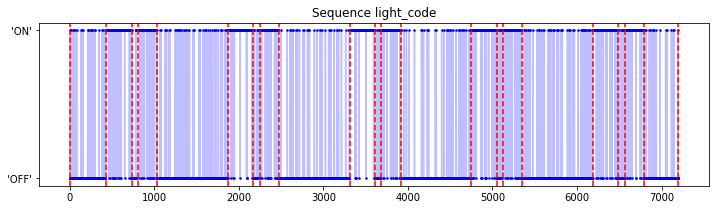

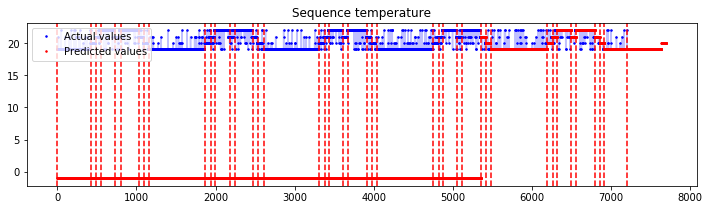

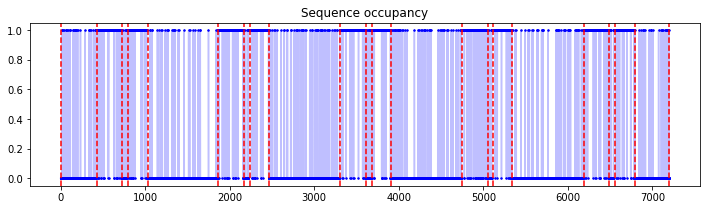

In [126]:
start_time = time.time()

simulator.run(plot=True, detect_rules=True, predict_seq=True)

#print_detected_change_points(simulator.get_detected_changes())
#print_rules(simulator.get_rules_sets(), 0)

end_time = time.time()
print(end_time - start_time)

plt.show()

In [129]:
#predict_ratio=0.75
target_seq_index = 1
print(len(sequences[target_seq_index])*predict_ratio)
print(len(sequences[target_seq_index]))

5256.0
7200


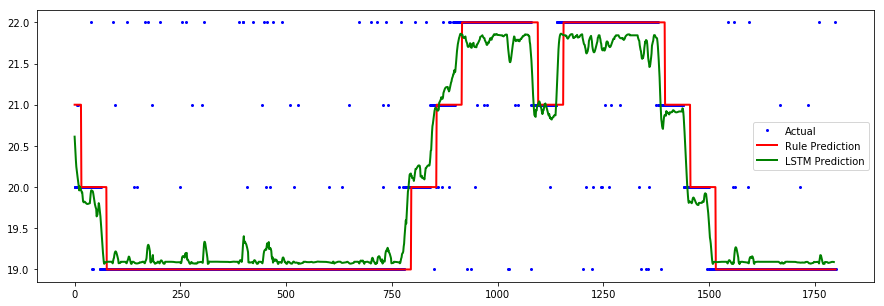

In [135]:
#import matplotlib.pyplot as plt2
plt.rcParams['figure.figsize'] = [15, 5]
predict_ratio=0.73

pr = int(len(sequences[target_seq_index])*predict_ratio)
predicted = simulator.predictor.predicted[pr:len(sequences[target_seq_index])]
real = sp.signal.medfilt(sequences[target_seq_index][pr:],21)

plt.plot(sequences[target_seq_index][5400:7200], 'b.', markersize=4, label="Actual")
#plt.plot(sequences[1][10800:], 'b-', alpha=0.1)
#for change_point in simulator.detected_change_points[1]:
#    plt2.axvline(change_point.at_, color='r', linestyle='--')

plt.plot(simulator.predictor.predicted[5400:7200], 'r', linewidth=2.0, label='Rule Prediction')
#xxx = np.append([0.25 for i in range(54)],np.array(newp))
plt.plot(newp, color='g',linewidth=2.0, label='LSTM Prediction')
#plt.xticks(np.arange(0, len(sequences[3]), 500))


plt.legend(loc='best')
plt.savefig('test.eps', format='eps', dpi=1000)
plt.show()


In [137]:
pr = int(len(sequences[1])*predict_ratio) + 20

predicted = simulator.predictor.predicted[5400:7200]
real = sequences[1][5400:7200] #sp.signal.medfilt(sequences[1][pr:],21)

rmse = np.sqrt(((predicted - real) ** 2).mean())
print('Mean Squared Error Rules: {}'.format(round(rmse, 5)))

rmse = np.sqrt(((newp[150:] - real) ** 2).mean())
print('Mean Squared Error LSTM: {}'.format(round(rmse, 5)))

Mean Squared Error Rules: 0.585
Mean Squared Error LSTM: 1.72023


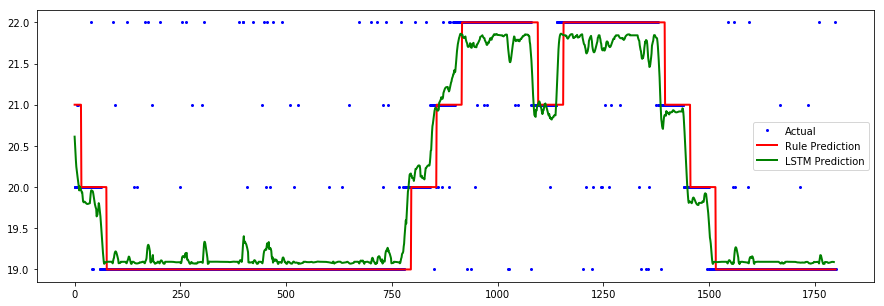

Mean Squared Error Rules: 0.585
Mean Squared Error LSTM: 1.69957


In [139]:
predicted = simulator.predictor.predicted[5400:7200]
predicted_lstm = newp
real = sequences[1][5400:7200]

plt.rcParams['figure.figsize'] = [15, 5]

plt.plot(real, 'b.', markersize=4, label="Actual")
#plt.plot(sequences[1][10800:], 'b-', alpha=0.1)
#for change_point in simulator.detected_change_points[1]:
#    plt2.axvline(change_point.at_, color='r', linestyle='--')

plt.plot(predicted, 'r', linewidth=2.0, label='Rule Prediction')
plt.plot(predicted_lstm, color='g',linewidth=2.0, label='LSTM Prediction')
#plt.xticks(np.arange(0, len(sequences[3]), 500))


plt.legend(loc='best')
plt.savefig('test.eps', format='eps', dpi=1000)
plt.show()

rmse_rules = np.sqrt(((predicted - real) ** 2).mean())
print('Mean Squared Error Rules: {}'.format(round(rmse_rules, 5)))

rmse_lstm = np.sqrt(((predicted_lstm - real) ** 2).mean())
print('Mean Squared Error LSTM: {}'.format(round(rmse_lstm, 5)))